# Vector 2: Geometries, Spatial Operations and Visualization Demo

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Background

https://autogis-site.readthedocs.io/en/latest/lessons/lesson-1/geometry-objects.html

Take a look at the first few sections of the shapely manual: https://shapely.readthedocs.io/en/stable/manual.html

Many of these are implemented in GeoPandas, and they will operate over GeoDataFrame and GeoSeries objects:
https://geopandas.org/en/stable/docs/reference.html

These are common functions, and good to have in your toolkit for additional spatial analysis
If you've taken a GIS class, you've definitely encountered these, probably through some kind of vector toolkit

## Interactive Discussion
### GeoDataFrame vs. GeoSeries
* https://geopandas.org/data_structures.html
* Indexing and selection - `iloc`, `loc`
* Pandas `squeeze`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.squeeze.html

### Geometry objects
* POINT, LINE, POLYGON
* Polygon vs. MultiPolygon

### GEOS geometry operations, as exposed by `shapely`
* GEOS https://libgeos.org/
* https://geopandas.org/geometric_manipulations.html
* Intersection
* Union
* Buffer

### Spatial joins with GeoPandas
* https://gisgeography.com/spatial-join/
* https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

### Visualization: Chloropleth and Heatmap
* https://geopandas.org/mapping.html

### Interactive plotting
* ipyleaflet, folium
* Basemap tiles with contextily

## Interactive Demo

In [ ]:
### Polygon creation
### Basic geometric operations on GeoDataFrame and Geometry objects

In [ ]:
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import xyzservices.providers as xyz
#plt.rcParams['figure.figsize'] = [10, 8]

In [ ]:
#%matplotlib widget

## Read in the projected GLAS points
* Ideally, use the file with equal-area projection exported during Lab04
* Note, you can right-click on a file in the Jupyterlab file browser, and select "Copy Path", then paste, but make sure you get the correct relative path to the current notebook (`../`)
* If you have issues with your file, you can recreate:
    * Read the original GLAS csv
    * Load into GeoDataFrame, define CRS (`'EPSG:4326'`)
    * Reproject with following PROJ string: `'+proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 +lon_0=-114.27'`

In [ ]:
#Loading output geopackage saved from Lab04
#aea_fn = '../04_Vector1_Geopandas_CRS_Proj/conus_glas_aea.gpkg'
#glas_gdf_aea = gpd.read_file(aea_fn)

In [ ]:
#Recreating using original csv and proj string from Lab04
aea_proj_str = '+proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 +lon_0=-114.27'
csv_fn = '../01_Shell_Github/data/GLAH14_tllz_conus_lulcfilt_demfilt.csv'
glas_df = pd.read_csv(csv_fn)
glas_gdf = gpd.GeoDataFrame(glas_df, crs='EPSG:4326', geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']))
glas_gdf_aea = glas_gdf.to_crs(aea_proj_str)

In [ ]:
glas_gdf_aea.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (709465.483 277418.898)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (709431.326 276549.914)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (709424.459 276376.270)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (709417.614 276202.405)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (709410.847 276028.547)


## Create a variable to store the `crs` of your GeoDataFrame
* Quickly print this out to verify everything looks good

In [ ]:
aea_crs = glas_gdf_aea.crs
aea_crs

<Derived Projected CRS: +proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Read in the state polygons

In [ ]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

## Limit to Lower48

In [ ]:
idx = states_gdf['NAME'].isin(['Alaska','Puerto Rico','Hawaii'])
states_gdf = states_gdf[~idx]

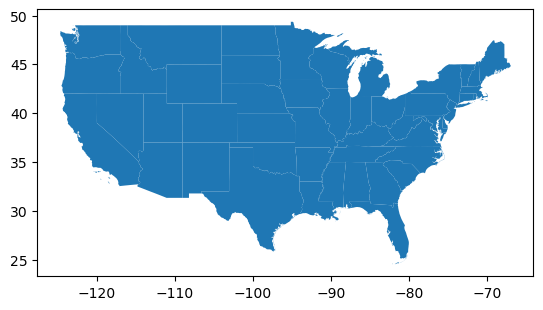

In [ ]:
states_gdf.plot();

## Reproject the states to match the `crs` of your points

In [ ]:
states_gdf_aea = states_gdf.to_crs(aea_crs)

## Create a quick plot to verify everything looks good
* Can re-use plotting code near the end of Lab04

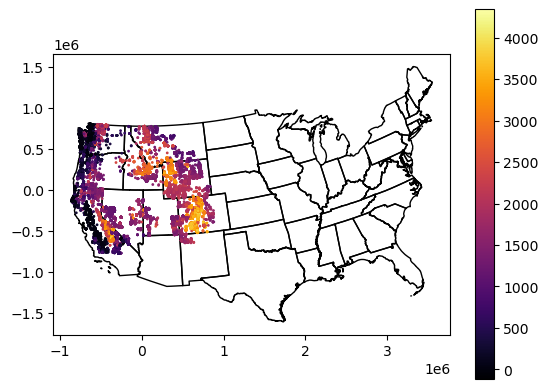

In [ ]:
f, ax = plt.subplots()
states_gdf_aea.plot(ax=ax, facecolor='none', edgecolor='k')
glas_gdf_aea.plot(ax=ax, column='glas_z', cmap='inferno', markersize=1, legend=True);

## Extract the MultiPolygon geometry object for Washington from your reprojected states GeoDataFrame
* Use the state 'NAME' value to isolate the approprate GeoDataFrame record for Washington
* Assign the `geometry` attribute for this record to a new variable called `wa_geom`
    * This is a little tricky
    * After a boolean filter to get the WA record, you will need to use something like `iloc[0]` to extract a GeoSeries, and then isolate the `geometry` attribute
        * `wa_geom = wa_gdf.iloc[0].geometry`
    * Use the python `type()` function to verify that your output type is `shapely.geometry.multipolygon.MultiPolygon`

In [ ]:
# This is a new GeoDataFrame with one entry
wa_gdf = states_gdf_aea[states_gdf_aea['NAME'] == 'Washington']

In [ ]:
wa_gdf

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
47,0400000US53,53,Washington,,66455.521,"MULTIPOLYGON (((-612752.940 729560.713, -61302..."


In [ ]:
type(wa_gdf)

geopandas.geodataframe.GeoDataFrame

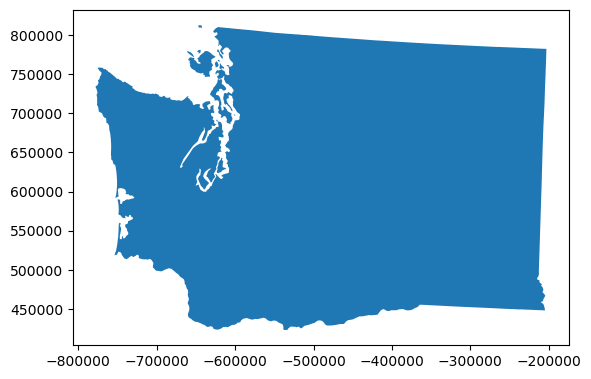

In [ ]:
wa_gdf.plot();

In [ ]:
wa_gdf

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
47,0400000US53,53,Washington,,66455.521,"MULTIPOLYGON (((-612752.940 729560.713, -61302..."


### Review loc, iloc, squeeze

In [ ]:
wa_gdf.loc[47]

GEO_ID                                              0400000US53
STATE                                                        53
NAME                                                 Washington
LSAD                                                           
CENSUSAREA                                            66455.521
geometry      MULTIPOLYGON (((-612752.9400995675 729560.7125...
Name: 47, dtype: object

In [ ]:
wa_gdf.iloc[0]

GEO_ID                                              0400000US53
STATE                                                        53
NAME                                                 Washington
LSAD                                                           
CENSUSAREA                                            66455.521
geometry      MULTIPOLYGON (((-612752.9400995675 729560.7125...
Name: 47, dtype: object

In [ ]:
wa_gdf.squeeze()

GEO_ID                                              0400000US53
STATE                                                        53
NAME                                                 Washington
LSAD                                                           
CENSUSAREA                                            66455.521
geometry      MULTIPOLYGON (((-612752.9400995675 729560.7125...
Name: 47, dtype: object

In [ ]:
type(wa_gdf.squeeze())

pandas.core.series.Series

In [ ]:
# This is the Geometry object for that one entry
wa_geom = wa_gdf.squeeze().geometry

In [ ]:
type(wa_geom)

shapely.geometry.multipolygon.MultiPolygon

## Inspect the Washington geometry object

### What happens when you pass the geometry object to `print()`?

In [ ]:
#print(wa_geom)

### What happens when you execute a notebook cell containing only the geometry object variable name? Oooh.
* Thanks Jupyter/iPython!

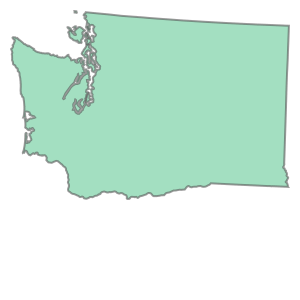

In [ ]:
wa_geom

### What is the geometry type?

In [ ]:
wa_geom.geom_type

'MultiPolygon'

## Find the geometric center of WA state
* See the `centroid` attribute
* You may have to `print()` this to see the coordinates

In [ ]:
#GeoDataFrame
#c = wa_gdf.centroid.iloc[0]
#MultiPolygon Geometry
c = wa_geom.centroid

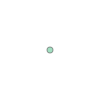

In [ ]:
c

In [ ]:
print(c)

POINT (-467157.473230843 616343.1305797546)


### How many individual polygons are contained in the WA geometry?  
* Hint: how would you get the number of elements in a standard Python tuple or list?  
* If more than one, why?

In [ ]:
list(wa_geom.geoms)

[<POLYGON ((-612752.94 729560.713, -613021.334 729273.422, -613662.604 728994...>,
 <POLYGON ((-617655.037 643357.018, -616062.698 642357.024, -616769.029 64134...>,
 <POLYGON ((-620939.954 780369.148, -619290.66 776796.516, -618975.967 775700...>,
 <POLYGON ((-642885.526 812063.484, -642146.899 809220.775, -642669.654 80890...>,
 <POLYGON ((-630090.827 766174.021, -630496.598 765572.995, -630334.207 76438...>,
 <POLYGON ((-658412.977 778304.396, -657537.277 778241.805, -656565.652 77757...>,
 <POLYGON ((-645363.093 780668.028, -644900.327 780993.484, -644161.267 78102...>,
 <POLYGON ((-619129.404 763618.245, -618629.246 763556.206, -617825.142 76168...>,
 <POLYGON ((-623703.558 766331.016, -622375.001 764843.757, -622224.419 76416...>,
 <POLYGON ((-622447.241 767581.22, -622337.148 767789.253, -620504.663 768373...>,
 <POLYGON ((-601852.039 698497.732, -601366.974 698721.75, -600888.341 698525...>,
 <POLYGON ((-615423.687 621888.803, -611189.472 623199.555, -609082.149 62361...>]

In [ ]:
len(wa_geom.geoms)

12

In [ ]:
wa_geom.area/1E6

175822.7066711332

## Cracking open the geometry collection

### Compute the area of each individual polygon
* Remember, this MultiPolygon object is iterable, so maybe list comprehension here?
* Store the output areas in a new list or array

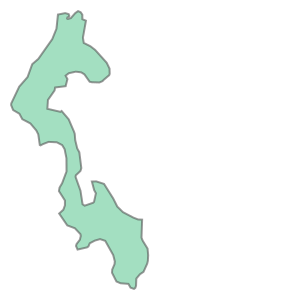

In [ ]:
wa_geom.geoms[0]

In [ ]:
wa_geom.geoms[0].area

463990359.19588774

In [ ]:
poly_area = [x.area for x in wa_geom.geoms]
poly_area

[463990359.19588774,
 107590054.65454032,
 24272338.175023668,
 12379518.750684448,
 623492527.1550797,
 21717224.08404236,
 12991256.233926358,
 21931206.771757536,
 24380918.94184941,
 4004131.839015948,
 1766748.2423283518,
 174504190387.08908]

### Isolate and render the polygons that have min and max area
* Remember the NumPy `argmax` function? Maybe useful here...

In [ ]:
maxidx = np.argmax(poly_area)
minidx = np.argmin(poly_area)

In [ ]:
maxidx

11

174504190387.08908


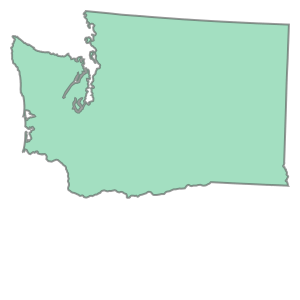

In [ ]:
print(wa_geom.geoms[maxidx].area)
wa_geom.geoms[maxidx]

1766748.2423283518


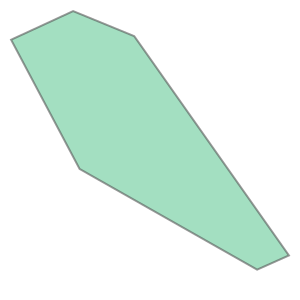

In [ ]:
print(wa_geom.geoms[minidx].area)
wa_geom.geoms[minidx]

### How many vertices are in the largest polygon?
* Let's start by looking at the `exterior` ring of the largest polygon geometry
    * This is actually a line, so if you ever need to convert a simple polygon geometry to a line geometry, now you know how to do it - use `exterior`! 
    * You should see an outline of WA state
* Now let's access the coordinates for this line geometry with `coords[:]`
    * This will return a list of (x,y) tuples for each vertex
* You already know how to determine the number of items in a list!

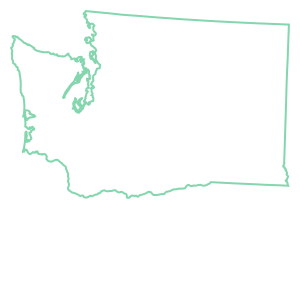

In [ ]:
wa_geom.geoms[maxidx].exterior

In [ ]:
type(wa_geom.geoms[maxidx].exterior)

shapely.geometry.polygon.LinearRing

In [ ]:
wa_geom.geoms[maxidx].exterior.coords

In [ ]:
#wa_geom.geoms[maxidx].exterior.coords[:]

In [ ]:
# Note -1 to remove repeated coord needed to close the polygon
len(wa_geom.geoms[maxidx].exterior.coords[:]) - 1

1365

## How many vertices in the smallest polygon?

In [ ]:
len(wa_geom.geoms[minidx].exterior.coords[:]) - 1

6

### Take a look at the list of (x,y) coordinates in the smallest polygon
* What do you notice about the first and last coordinate?

In [ ]:
wa_geom.geoms[minidx].exterior.coords[:]

[(-601852.0391967978, 698497.7315981847),
 (-601366.9738585693, 698721.7499047287),
 (-600888.3410211434, 698525.3867155112),
 (-599678.0363506506, 696809.5398449603),
 (-599926.7737744286, 696698.4274957966),
 (-601315.8650362622, 697486.3070502713),
 (-601852.0391967978, 698497.7315981847)]

This is a closed polygon!  It starts and ends at the same point.  So technically, you have one less vertex than the total number of points in the polygon.

## Determine the perimeter of WA state in km
* This should be quick - just use an attribtue of the MultiPolygon geometry

In [ ]:
wa_geom.length/1E3

3513.2810843205025

## Explore the `simplify()` method for your MultiPolygon
* This can be very useful if you have complex geometry objects that require a lot of memory
    * Perhaps a line from a GPS track, or a polygon extracted from a raster with a vertex at each pixel
    * You can simplify, preserve almost all of the original information, and remove many (sometimes most) of the redundant/unnecessary vertices
* https://shapely.readthedocs.io/en/latest/manual.html#object.simplify
* Need to provide a `tolerance` in units of meters
    * Try 100, 1000, 10000, 100000
    * How does this affect the perimeter measurement?

In [ ]:
def smart_simplify(geom, tol):
    newgeom = geom.simplify(tol)
    newvertcount = sum(len(x.exterior.coords[:]) for x in newgeom.geoms)
    gpd.GeoSeries(newgeom).plot(figsize=(4,3))
    print(tol, '%0.1f' % (newgeom.length/1E3), newvertcount)

Tolerance Perimieter Num vertices
100 3512.1 1436
1000 3416.0 427
10000 3009.8 109
100000 2449.0 68


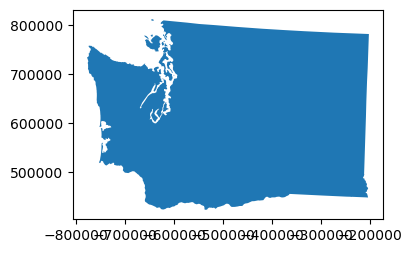

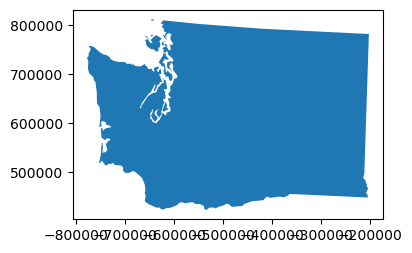

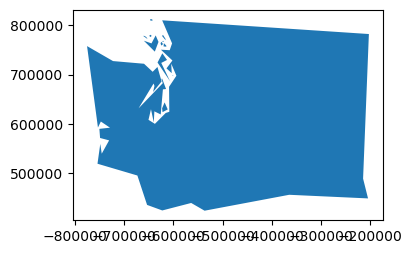

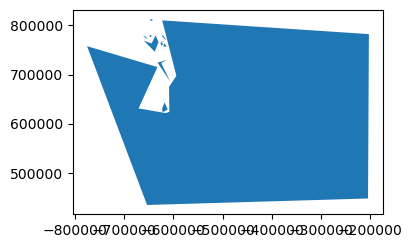

In [ ]:
print("Tolerance", "Perimieter", "Num vertices")
for i in (100,1000,10000,100000):
    smart_simplify(wa_geom, i)

### Coastline Paradox
* https://en.wikipedia.org/wiki/Coastline_paradox

### Extra Credit: What percentage of the total WA state perimeter is from islands?

In [ ]:
wa_geom.geoms[maxidx].length / wa_geom.length

0.8513022231543143

In [ ]:
(1.0 - (wa_geom.geoms[maxidx].length / wa_geom.length))*100

14.869777684568575

## Unite the West Coast!
* Let's create a single Multipolygon for West Coast states: Washington, Oregon and California
* Start by extracting those states to a new GeoDataFrame - can use the `isin()` function for Pandas, which is similar to built-in `in` operation in Python

In [ ]:
idx = states_gdf_aea['NAME'].isin(['Washington','Oregon','California'])
westcoast_gdf = states_gdf_aea[idx]
westcoast_gdf

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-715337.404 -425936.004, -7153..."
37,0400000US41,41,Oregon,,95988.013,"POLYGON ((-594594.782 433232.266, -593459.687 ..."
47,0400000US53,53,Washington,,66455.521,"MULTIPOLYGON (((-612752.940 729560.713, -61302..."


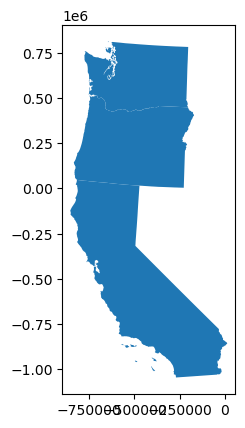

In [ ]:
westcoast_gdf.plot();

## Combine the states as a single MultiPolygon geometry
* See the `unary_union` attribute 

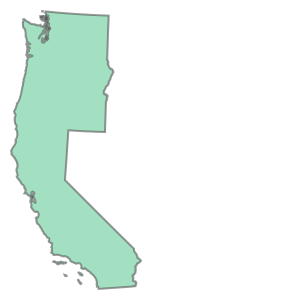

In [ ]:
westcoast_geom = westcoast_gdf.unary_union
westcoast_geom

Note: If you have a column that classifies features in a GeoDataFrame (e.g., a column for `region` with a shared value of 'West Coast' for these polygons), you can also use `dissolve(by='region')` to create a new GeoDataFrame of merged polygons

## Now buffer the combined geometry
* Use a 50 km buffer

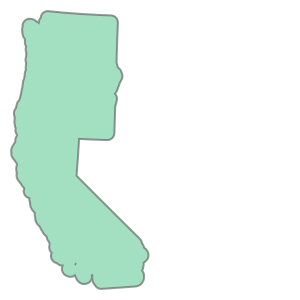

In [ ]:
westcoast_geom_buff = westcoast_geom.buffer(50000)
westcoast_geom_buff

In [ ]:
type(westcoast_geom_buff)

shapely.geometry.polygon.Polygon

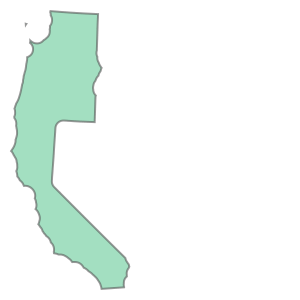

In [ ]:
#Buffer distance can be negative
westcoast_geom_erode = westcoast_geom.buffer(-50000)
westcoast_geom_erode

## Use a `difference` operation to isolate the buffered region around the individual polygons
* This is sometimes useful if you need to extract statistics from another dataset

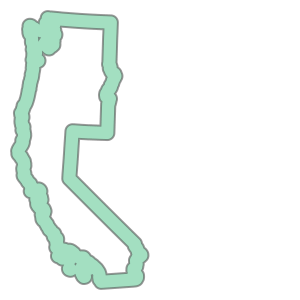

In [ ]:
westcoast_geom_buff.difference(westcoast_geom_erode)

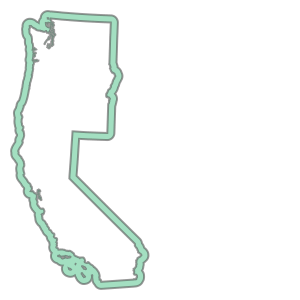

In [ ]:
westcoast_geom_buff.difference(westcoast_geom)

### Somebody should put that on a sticker!

## RGI glacier polygons

Let's grab some glacier outline poygons from the Randolph Glacier Inventory (RGI) v6.0: https://www.glims.org/RGI/

In [ ]:
#Fetch the zip file for Region 02 (Western North America)
#rgi_zip_fn = '02_rgi60_WesternCanadaUS.zip'

#Download
#if not os.path.exists(rgi_zip_fn):
#    url = 'https://www.glims.org/RGI/rgi60_files/' + rgi_zip_fn
#    myfile = requests.get(url)
#    open(rgi_zip_fn, 'wb').write(myfile.content)

#Specify the shapefile filename within zip archive
#rgi_fn = 'zip://02_rgi60_WesternCanadaUS.zip!02_rgi60_WesternCanadaUS.shp'

In [ ]:
#Alternatively, just load zip file and decompress shp directly from url!
rgi_fn = 'zip+https://www.glims.org/RGI/rgi60_files/02_rgi60_WesternCanadaUS.zip!02_rgi60_WesternCanadaUS.shp'

## Load RGI shapefile using Geopandas
* Very easy with `read_file()` meethod

In [ ]:
rgi_gdf = gpd.read_file(rgi_fn)

In [ ]:
rgi_gdf.shape

(18855, 23)

In [ ]:
rgi_gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.00001,G238765E49002N,20049999,20069999,-121.235,49.0019,2,4,0.073,1938,...,345,304,0,0,0,0,0,9,None,"POLYGON ((-121.23718 49.00120, -121.23707 49.0..."
1,RGI60-02.00002,G238410E49162N,20049999,20069999,-121.590,49.1617,2,4,0.262,1726,...,6,817,0,0,0,0,0,9,None,"POLYGON ((-121.59118 49.15868, -121.59118 49.1..."
2,RGI60-02.00003,G238791E49163N,20049999,20069999,-121.209,49.1627,2,4,0.307,2002,...,100,478,0,0,0,0,0,9,None,"POLYGON ((-121.20751 49.16608, -121.20669 49.1..."
3,RGI60-02.00004,G238399E49166N,20049999,20069999,-121.601,49.1657,2,4,0.184,1563,...,15,376,0,0,0,0,0,9,None,"POLYGON ((-121.59654 49.16729, -121.59700 49.1..."
4,RGI60-02.00005,G238389E49167N,20049999,20069999,-121.611,49.1666,2,4,0.274,1668,...,50,676,0,0,0,0,0,9,None,"POLYGON ((-121.60800 49.16802, -121.60803 49.1..."


That's it!

In [ ]:
#By default a new integer index is created.  Can use the RGI ID as our index
#rgi_gdf = rgi_gdf.set_index('RGIId')

## Create a quick plot

In [ ]:
#%matplotlib widget

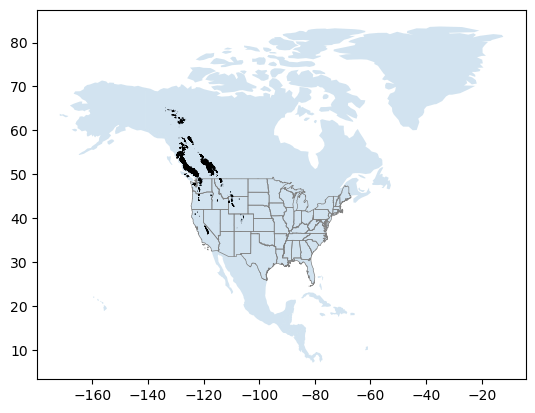

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world['continent'] == 'North America'].plot(alpha=0.2)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='0.5', linewidth=0.5)
rgi_gdf.plot(ax=ax, edgecolor='k', linewidth=0.5);

## Clip RGI polygons to WA state
GeoPandas makes spatial selection easy.  

We'll have two options: 1) using a bounding box, and 2) using an arbitrary polygon.

#### 1. Bounding box

In [ ]:
wa_gdf

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
47,0400000US53,53,Washington,,66455.521,"MULTIPOLYGON (((-612752.940 729560.713, -61302..."


In [ ]:
xmin, ymin, xmax, ymax = wa_gdf.to_crs('EPSG:4326').total_bounds

In [ ]:
print(xmin, ymin, xmax, ymax)

-124.733174 45.543541 -116.915989 49.002494000000006


#### Create new GeoDataFrame from output of simple spatial filter with GeoPandas `cx` function
* https://geopandas.org/indexing.html

In [ ]:
rgi_gdf_wa = rgi_gdf.cx[xmin:xmax, ymin:ymax]

In [ ]:
print("Number of RGI polygons before:",rgi_gdf.shape[0])
print("Number of RGI polygons after:", rgi_gdf_wa.shape[0])

Number of RGI polygons before: 18855
Number of RGI polygons after: 1969


#### Quick plot to verify

<Axes: >

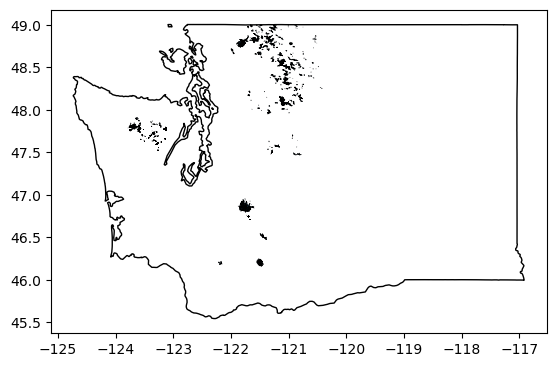

In [ ]:
ax = rgi_gdf_wa.plot(edgecolor='k', linewidth=0.5)
wa_gdf.to_crs('EPSG:4326').plot(ax=ax, facecolor='none')

#### 2. Clip points to arbitrary Polygon geometry
* Let's determine convex hull of the complex WA state multipologon
* https://en.wikipedia.org/wiki/Convex_hull

In [ ]:
wa_gdf_chull = wa_gdf.to_crs('EPSG:4326').unary_union.convex_hull

In [ ]:
#Check the type
type(wa_gdf_chull)

shapely.geometry.polygon.Polygon

#### Preview geometry
Note that geometry objects (points, lines, polygons, etc.) will render directly in the Jupyter notebook!  Great for quick previews.

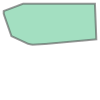

In [ ]:
wa_gdf_chull

In [ ]:
print(wa_gdf_chull)

POLYGON ((-122.294901 45.543541, -122.33150200000001 45.548241000000004, -122.43867400000002 45.56358500000004, -122.64390700000001 45.609739000000005, -122.675008 45.618039000000024, -122.73810900000001 45.644137999999955, -124.080671 46.26723900000002, -124.08218700000002 46.26915900000001, -124.67242700000001 47.964414000000005, -124.733174 48.16339299999998, -124.73182800000001 48.38115699999996, -124.725839 48.386012000000065, -124.71694700000002 48.38977600000004, -123.090546 49.001976000000006, -123.03539300000001 49.00215400000004, -122.75802 49.00235700000007, -122.251063 49.002494000000006, -117.607323 49.000842999999996, -117.26819200000001 48.99992800000007, -117.032351 48.99918799999996, -116.921258 46.16479500000001, -116.915989 45.99541300000002, -121.145534 45.607885999999986, -121.167852 45.60609800000006, -122.26670100000001 45.54384099999998, -122.294901 45.543541))


#### Compute intersection between all RGI polygons and the convex hull
Use the GeoDataFrame `intersects()` function.  
This will return a Boolean DataSeries, True if points intersect the polygon, False if they do not

In [ ]:
rgi_gdf_idx = rgi_gdf.intersects(wa_gdf_chull)

In [ ]:
rgi_gdf_idx

0         True
1        False
2        False
3        False
4        False
         ...  
18850    False
18851    False
18852    False
18853    False
18854    False
Length: 18855, dtype: bool

#### Extract records with True for the intersection

In [ ]:
print("Number of RGI polygons before:",rgi_gdf.shape[0])
rgi_gdf_wa = rgi_gdf[rgi_gdf_idx]
print("Number of RGI polygons after:", rgi_gdf_wa.shape[0])

Number of RGI polygons before: 18855
Number of RGI polygons after: 1969


#### Quick plot to verify
Note latitude range

In [ ]:
#rgi_gdf_wa.plot(edgecolor='k', linewidth=0.5);

In [ ]:
rgi_gdf_wa_aea = rgi_gdf_wa.to_crs(aea_crs)

In [ ]:
rgi_gdf_wa_aea.geometry.centroid.x

0       -511163.085177
13996   -696970.674516
13997   -677696.146343
13998   -697448.193941
13999   -697172.316315
             ...      
18816   -567151.522137
18817   -570038.180556
18818   -570576.721676
18819   -556026.674614
18821   -608142.914128
Length: 1969, dtype: float64

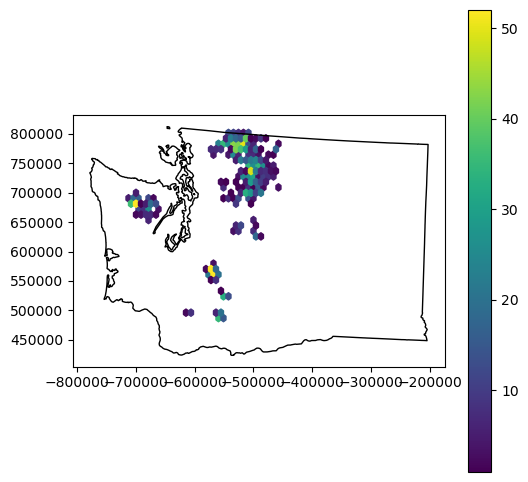

In [ ]:
f, ax = plt.subplots(figsize=(6,6))
x = rgi_gdf_wa_aea.geometry.centroid.x
y = rgi_gdf_wa_aea.geometry.centroid.y
hb = ax.hexbin(x, y, gridsize=30, mincnt=1)
ax.set_aspect('equal')
wa_gdf.plot(ax=ax, facecolor='none')
plt.colorbar(hb, ax=ax);

## Merge GLAS points and RGI polygons

Earlier we computed some statistics for the full CONUS GLAS sample and hex bins.  Now let's analyze the GLAS points that intersect each RGI glacier polygon. 

One approach would be to loop through each glacier polygon, and do an intersection operation with all points.  But this is inefficient, and doesn't scale well.  It is much more efficient to do a spatial join between the points and the polygons, then groupby and aggregate to compute the relevant statistics for all points that intersect each glacier polygon.

You may have learned how to perform a join or spatial join in a GIS course.  So, do we need to open ArcMap or QGIS here?  Do we need a full-fledged spatial database like PostGIS?  No!  GeoPandas has you covered.

* Start by reviewing the Spatial Join documentation here: http://geopandas.org/mergingdata.html
* Use the geopandas `sjoin` method: http://geopandas.org/reference/geopandas.sjoin.html

## First, we need to make sure all inputs have the same projection
* Reproject the RGI polygons to match our point CRS (custom Albers Equal-area)

In [ ]:
glas_gdf_aea.crs

<Derived Projected CRS: +proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
rgi_gdf_wa_aea.crs

<Derived Projected CRS: +proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Optional: isolate relevant columns to simplify our output

In [ ]:
glas_gdf_aea.columns

Index(['decyear', 'ordinal', 'lat', 'lon', 'glas_z', 'dem_z', 'dem_z_std',
       'lulc', 'geometry'],
      dtype='object')

In [ ]:
rgi_gdf_wa_aea.columns

Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'geometry'],
      dtype='object')

In [ ]:
glas_col = ['decyear', 'glas_z', 'geometry']
rgi_col = ['RGIId', 'Area', 'Name', 'geometry']

glas_gdf_aea_lite = glas_gdf_aea[glas_col]
rgi_gdf_wa_aea_lite = rgi_gdf_wa_aea[rgi_col]

In [ ]:
glas_gdf_aea_lite

,decyear,glas_z,geometry
0,2003.139571,1398.51,POINT (709465.483 277418.898)
1,2003.139571,1387.11,POINT (709431.326 276549.914)
2,2003.139571,1392.83,POINT (709424.459 276376.270)
3,2003.139571,1384.24,POINT (709417.614 276202.405)
4,2003.139571,1369.21,POINT (709410.847 276028.547)
...,...,...,...
65231,2009.775995,1556.16,POINT (-243698.930 -453031.309)
65232,2009.775995,1556.02,POINT (-243717.616 -452858.707)
65233,2009.775995,1556.19,POINT (-243736.378 -452685.769)
65234,2009.775995,1556.18,POINT (-243755.227 -452512.827)


In [ ]:
rgi_gdf_wa_aea_lite

,RGIId,Area,Name,geometry
0,RGI60-02.00001,0.073,None,"POLYGON ((-511333.014 799883.904, -511328.182 ..."
13996,RGI60-02.13997,0.013,WA,"POLYGON ((-696886.604 676231.697, -696885.090 ..."
13997,RGI60-02.13998,0.017,WA,"POLYGON ((-677571.972 662980.297, -677571.401 ..."
13998,RGI60-02.13999,0.080,WA,"POLYGON ((-697318.076 691671.086, -697317.024 ..."
13999,RGI60-02.14000,0.047,WA,"POLYGON ((-697038.702 691765.708, -697038.756 ..."
...,...,...,...,...
18816,RGI60-02.18817,3.567,Cowlitz Glacier WA,"POLYGON ((-566398.505 562478.777, -566326.668 ..."
18817,RGI60-02.18818,1.551,Wilson Glacier WA,"POLYGON ((-570424.477 562607.097, -570382.029 ..."
18818,RGI60-02.18819,0.105,The Turtle WA,"POLYGON ((-570382.029 562658.538, -570424.477 ..."
18819,RGI60-02.18820,0.536,WA,"POLYGON ((-555598.936 782076.351, -555652.068 ..."


## Now try a spatial join between these two 
* Use the GLAS points as the "left" GeoDataFrame and the RGI polygons as the "right" GeoDataFrame
* Start by using default options (`op='intersects', how='inner'`)
* Note the output geometry type and columns

In [ ]:
#gpd.sjoin?

In [ ]:
%%time
glas_gdf_aea_rgi = gpd.sjoin(glas_gdf_aea_lite, rgi_gdf_wa_aea_lite, how='inner')
glas_gdf_aea_rgi

CPU times: user 53.8 ms, sys: 6.1 ms, total: 59.9 ms
Wall time: 58.8 ms


,decyear,glas_z,geometry,index_right,RGIId,Area,Name
1032,2003.162887,1798.45,POINT (-536016.695 765363.954),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5393,2003.753883,1826.79,POINT (-535556.175 765036.880),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5394,2003.753883,1795.05,POINT (-535567.491 765209.022),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5395,2003.753883,1768.91,POINT (-535579.036 765381.071),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
5396,2003.753883,1745.11,POINT (-535590.709 765553.353),17368,RGI60-02.17369,2.819,Noisy Creek Glacier
...,...,...,...,...,...,...,...
48992,2007.223249,2176.08,POINT (-572565.453 571897.399),14273,RGI60-02.14274,0.036,WA
48996,2007.223250,2050.27,POINT (-572609.529 572592.042),14265,RGI60-02.14266,0.082,WA
54878,2007.827915,2154.16,POINT (-480120.576 740457.368),18246,RGI60-02.18247,0.036,WA
54898,2007.827916,2169.48,POINT (-484242.630 795899.403),17668,RGI60-02.17669,0.034,WA


## Check number of records

In [ ]:
print("Number of RGI polygons before:", rgi_gdf_wa_aea_lite.shape[0])
print("Number of GLAS points before:", glas_gdf_aea.shape[0])
print("Number of GLAS points that intersect RGI polygons:", glas_gdf_aea_rgi.shape[0])

Number of RGI polygons before: 1969
Number of GLAS points before: 65236
Number of GLAS points that intersect RGI polygons: 562


## Check number of GLAS points per RGI polygon

In [ ]:
glas_gdf_aea_rgi['RGIId'].value_counts()

RGI60-02.14588    49
RGI60-02.17727    43
RGI60-02.14005    33
RGI60-02.14103    30
RGI60-02.17726    29
                  ..
RGI60-02.17581     1
RGI60-02.14007     1
RGI60-02.14050     1
RGI60-02.14587     1
RGI60-02.14036     1
Name: RGIId, Length: 84, dtype: int64

## Which glacier has the greatest number of points?

Some notes on indexing and selecting from Pandas DataFrame: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

Here we'll use the `iloc` function to pull out the record for the RGIId key with the highest point count.

In [ ]:
label = glas_gdf_aea_rgi['RGIId'].value_counts().index[0]
print(label)

RGI60-02.14588


In [ ]:
rgi_maxcount = rgi_gdf_wa_aea_lite[rgi_gdf_wa_aea_lite['RGIId'] == label]
rgi_maxcount

,RGIId,Area,Name,geometry
14587,RGI60-02.14588,0.327,Swift Glacier WA,"POLYGON ((-609340.040 494851.618, -609338.250 ..."


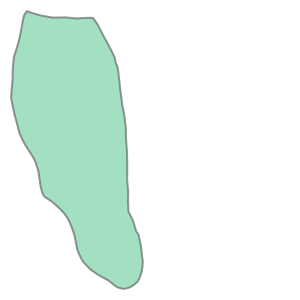

In [ ]:
rgi_maxcount.iloc[0].geometry

## Interactive plots
Commented out to reduce notebook filesize

In [ ]:
#rgi_maxcount.explore(tiles=xyz.Esri.WorldImagery)

In [ ]:
#glas_gdf_aea_rgi.explore()

In [ ]:
#m = rgi_gdf_wa_aea_lite.explore(tiles="Stamen Terrain")
#glas_gdf_aea_rgi.explore(m=m, column='glas_z', cmap='inferno')

In [ ]:
def plotcol(gdf, col='glas_z'):
    clim = gdf[col].quantile((0.02, 0.98)).values
    m = gdf[::1].explore(tiles=xyz.Esri.WorldImagery, column=col, cmap='inferno', vmin=clim[0], vmax=clim[1])
    return m

In [ ]:
#plotcol(glas_gdf_aea_rgi, col='glas_z')